In [3]:
import pandas as pd 
from matplotlib import pyplot as plt 
import numpy as np 
import utils
import matplotlib 
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.impute import KNNImputer
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
data = pd.read_csv('data/data.csv')

In [5]:
df = pd.read_csv('data/data.csv')
df['date'] = pd.to_datetime(df.date, infer_datetime_format=True)
df = df.set_index('date', drop=True)
df = df.sort_index()
df.tail()

,PM2.5,exog
date,,
2017-02-21 19:00:00,NaN,1.4
2017-02-21 20:00:00,NaN,1.5
2017-02-21 21:00:00,NaN,1.1
2017-02-21 22:00:00,NaN,1.7
2017-02-21 23:00:00,NaN,2.0


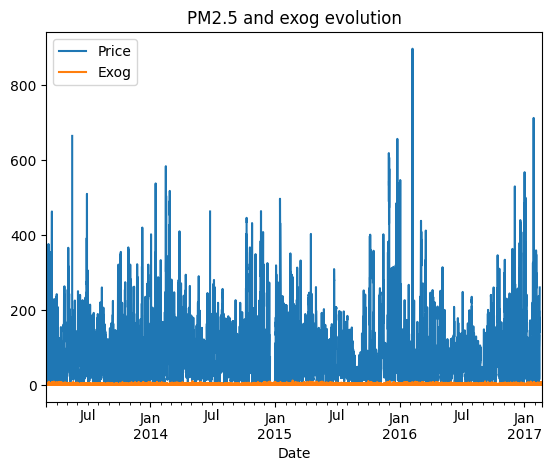

In [6]:
df['PM2.5'].plot()
pd.Series(df.exog, index=df.index).plot()
plt.xlabel('Date')
plt.title('PM2.5 and exog evolution')
plt.legend(['Price','Exog'],loc=2)

In [7]:
#imputer = KNNImputer()
#df = df.resample('H').asfreq()
#data_imputed = imputer.fit_transform(df)
#data_imputed

In [8]:
train_val = df.iloc[:-24*7]
test = df.iloc[-24*7:]

In [9]:
from sklearn.impute import KNNImputer
imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
imputed_train = imputer.fit_transform(train_val) # This may take a bit to run
train_val = pd.DataFrame(imputed_train, index=train_val.index, columns=train_val.columns)



In [11]:
train = train_val
val = test

train_pm = train['PM2.5']
train_exo = train['exog']
val_pm = val['PM2.5']
val_exo = val['exog']

In [12]:
train_pm_log = train_pm.map(np.log)
train_pm_log_detrend = train_pm_log.diff()
train_pm_log_detrend_without_nans =  train_pm_log_detrend.dropna()
train_pm_log_detrend_without_nans

date
2013-03-01 01:00:00    0.693147
2013-03-01 02:00:00   -0.133531
2013-03-01 03:00:00   -0.154151
2013-03-01 04:00:00   -0.693147
2013-03-01 05:00:00    0.510826
                         ...   
2017-02-14 19:00:00    0.024098
2017-02-14 20:00:00    0.004751
2017-02-14 21:00:00    0.073092
2017-02-14 22:00:00    0.084438
2017-02-14 23:00:00    0.051293
Name: PM2.5, Length: 34727, dtype: float64

/home/francisco/.virtualenvs/slu01/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


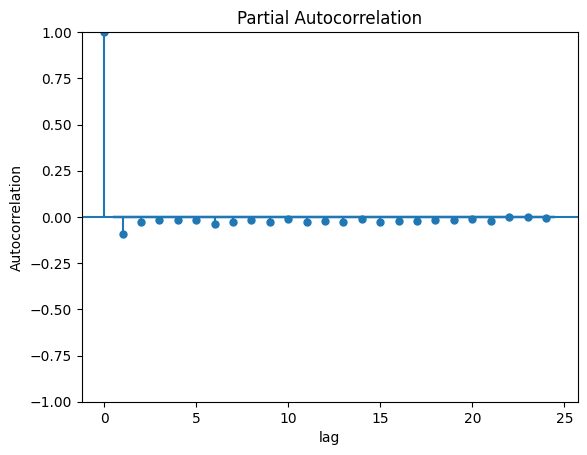

In [13]:
plot_pacf(train_pm_log_detrend_without_nans, alpha=0.05, lags=24)#, if you're curious take also a look at the acf
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

In [14]:
sarimax = pm.AutoARIMA(trace=True, suppress_warnings=True, m=1, maxiter=20, method ='nm')
sarimax.fit(train_pm_log)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26696.422, Time=3.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27046.405, Time=1.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26762.359, Time=2.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26747.060, Time=2.94 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27044.409, Time=0.45 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26608.076, Time=3.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=26730.301, Time=3.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26720.257, Time=3.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26460.935, Time=3.51 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=26719.311, Time=4.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=27043.197, Time=3.49 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=26483.832, Time=3.85 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=26708.737, Time=4.01 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=26255.248, Time=3.91 sec
 ARIMA(3,1,4)(0,0,0

AutoARIMA(maxiter=20, method='nm', trace=True)

### PREDICTION IN-SAMPLE

In [16]:
predictions = sarimax.predict_in_sample(train_pm_log)
predictions = np.array(np.exp(predictions))

real_emissions_train_log = np.array(np.exp(train_pm_log))
mae = mean_absolute_error(predictions,real_emissions_train_log)
mae

12.346008190228536

### FORECAST NEXT 168H

In [19]:
forecast

array([243.99557796, 231.50106338, 220.63400819, 210.86764963,
       202.17616016, 194.36351347, 187.34950388, 181.02292253,
       175.30981155, 170.13593011, 165.44248139, 161.17583581,
       157.29067302, 153.74675489, 150.50917396, 147.54708445,
       144.83338404, 142.34406978, 140.05788483, 137.95592272,
       136.02133992, 134.23908578, 132.5956841 , 131.07903921,
       129.6782723 , 128.38357841, 127.1861034 , 126.07783674,
       125.05151834, 124.10055708, 123.21895959, 122.40126769,
       121.64250342, 120.93812052, 120.28396157, 119.67622004,
       119.11140658, 118.58631902, 118.0980157 , 117.64379154,
       117.22115674, 116.82781754, 116.46165908, 116.12072992,
       115.80322799, 115.5074881 , 115.23197045, 114.97525034,
       114.73600878, 114.51302398, 114.30516362, 114.11137777,
       113.93069244, 113.76220374, 113.60507247, 113.45851918,
       113.32181971, 113.19430099, 113.07533729, 112.96434667,
       112.86078782, 112.76415705, 112.67398559, 112.58

In [17]:
'''
forecast = sarimax.predict(168)
forecast =  np.array(np.exp(forecast))

mae = mean_absolute_error (forecast,np.array(val_pm))
mae'''

ValueError: Input contains NaN.

In [ ]:
test.plot()
pd.Series(forecast, index=test.index).plot()
plt.xlabel('Time')
plt.title('Monthly CO2 emissions (gCO2eq)')
plt.legend(['original','forecast'],loc=2)
print(mae)

### one Multi-Step

In [20]:
# Don't forget to fit your sarimax model again
# You will need to make a for loop that updates the model
# Note that this case is slightly different from the learning notebooks, where we used the exogenous data to do a
# multi-step forecast. Here we need to use the exogenous data in the context of multiple one-step forecasts, this 
# means we need to have an update loop where we also include the new values of the exogenous data 
# (similar to what was done in Q7.1).

#exog_train_log = exog_train['Value'].map(np.log)
#exog_train_log = np.array(exog_train_log).reshape(-1, 1)



#train_pm = train['PM2.5']
#train_exo = train['exog']
#val_pm = val['PM2.5']
#val_exo = val['exog']

sarimax_forecast_one_step_refit = []




#sarimax = pm.AutoARIMA(trace=True, suppress_warnings=True, m=S, maxiter=20, method ='nm')

sarimax.fit(train_pm_log,np.array(train_exo).reshape(-1, 1))  

val_pm_logged = val_pm.map(np.log)
val_exo = np.array(val_exo).reshape(-1, 1)
#exog_test_log = np.array(exog_test_log).reshape(-1, 1)
# Update loop

for i in np.arange(0,168): # run it before the rest of the loop
    
    next_step_forecast_exo = sarimax.predict(1,val_exo[i].reshape(-1, 1))[0]

    sarimax_forecast_one_step_refit.append(next_step_forecast_exo)

    sarimax = sarimax.update(val_pm_logged[i:i+1] , val_exo[i:i+1])







Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=26622.250, Time=3.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=26995.144, Time=2.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=26702.263, Time=2.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=26685.039, Time=3.44 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=28240.454, Time=3.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=26519.832, Time=3.55 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=26664.192, Time=3.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=26650.761, Time=3.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=26422.820, Time=3.74 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=26649.008, Time=3.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=26994.085, Time=3.78 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=26446.942, Time=3.89 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=26635.698, Time=3.98 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=26260.388, Time=4.02 sec
 ARIMA(3,1,4)(0,0,0

In [25]:
sarimax_forecast_one_step_refit_exp = np.array(np.exp(sarimax_forecast_one_step_refit))
sarimax_forecast_one_step_refit_exp

array([249.30355268, 232.82228805, 219.63695874, 199.08007675,
       195.78958787, 185.38256254, 171.73963496, 157.22330692,
       156.22948606, 141.4572953 , 130.74095474, 122.16593637,
       123.45768187, 115.18170072, 105.9611597 ,  97.05108309,
        91.60193727,  86.32638054,  90.54960862,  84.57949732,
        79.05276511,  76.21945896,  73.42419089,  70.17321688,
        67.6132037 ,  64.97789922,  66.58087715,  64.951484  ,
        63.51327717,  62.24202463,  60.78588609,  59.56102798,
        59.56642555,  59.09569171,  55.81197078,  55.61149866,
        53.83639397,  54.25182137,  55.26177624,  54.22015435,
        55.28735277,  55.96556491,  56.52517784,  58.08378588,
        57.63071621,  56.81559777,  54.95553342,  54.54939203,
        54.87412478,  54.52471232,  54.69775161,  55.30812397,
        54.75591512,  55.2111001 ,  53.98396133,  54.31532478,
        54.00813131,  52.98833664,  51.46111559,  51.402631  ,
        51.46440128,  49.92543661,  51.15913063,  50.50

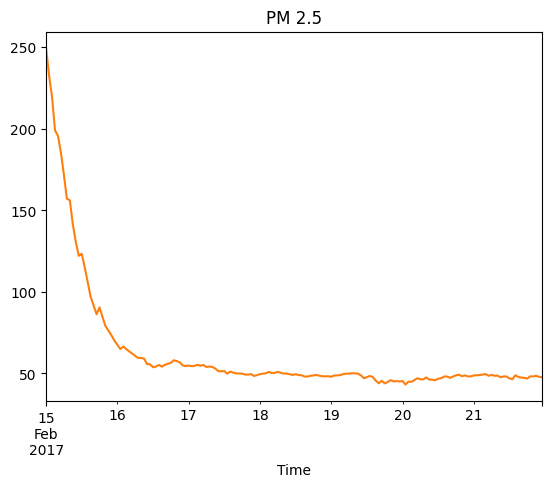

In [26]:
val_pm.plot()
pd.Series(sarimax_forecast_one_step_refit_exp, index=val_pm.index).plot()
plt.xlabel('Time')
plt.title('PM 2.5')


submission=pd.DataFrame(sarimax_forecast_one_step_refit_exp, columns=["PM2.5"])

submission.to_csv("data/submission_2_AutoSarimax.csv", index=False)

In [ ]:
sarimax_forecast_one_step_refit_exp = np.array(np.exp(sarimax_forecast_one_step_refit))
mae = mean_absolute_error(sarimax_forecast_one_step_refit_exp, val_pm)
mae

In [21]:
submission=pd.DataFrame(sarimax_forecast_one_step_refit_exp, columns=["PM2.5"])

submission.to_csv("data/submission_2_AutoSarimax.csv", index=False)

NameError: name 'sarimax_forecast_one_step_refit_exp' is not defined